In [20]:
import psycopg2
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [21]:
USERNAME = 'dryu'
PWD = 'VRyrf4cXDtccxT4b'
DB_HOST = [('olympus','olympus.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
           ,('atlas','atlas.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
          ,('verizon','rr.verizon.amer-ignite.digitalturbine.com')]

In [22]:
conn_olympus = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                                f"dbname={DB_HOST[0][0]} host={DB_HOST[0][1]}")
conn_atlas = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                              f"dbname={DB_HOST[1][0]} host={DB_HOST[1][1]}")
cur_olympus = conn_olympus.cursor()
cur_atlas = conn_atlas.cursor()


In [23]:
query = """
    select
        ctp.sort_hour as preload_hour
        , date(ctp.tracking_time) as preload_date
        , ctp.countrycode
        , ctp.campaign_id
        , ctp.site_id
        , ctp.placement_id
        , ctp.android_package_name
        , ctp.billing_type
        , ctp.mmppartner
        , ctp.homescreen
        , ctp.sti_type
        , ctp.flows
        , count(distinct ctp.referrer) as preload_count
        , count(distinct cti.referrer) as install_count
        , count(distinct pi.referrer) as event_count
    from rawdata.campaign_tracking_active_preload ctp
    left join rawdata.campaign_tracking_active_install cti 
        on ctp.referrer = cti.referrer
        and cti.tracking_time >= ctp.tracking_time 
        and right(cti.referrer,1) = '0'        
    left join rawdata.pi_data pi 
        on cti.referrer = pi.referrer
        and pi.event_date >= cti.tracking_time
        and right(pi.referrer,1) = '0'       
    join rawdata.site s 
        on ctp.site_id = s.site_id
    join rawdata.campaign c
        on c.campaign_id = ctp.campaign_id
    where 
        date(ctp.tracking_time) >= date('03-01-2021')
        and date(ctp.tracking_time) <= date('03-17-2021')
        and right(ctp.referrer,1) = '0'
        and (((lower(pi.event) like '%purchase%'
        or lower(pi.event) like '%order%'
        or lower(pi.event) like '%revenue%') 
        and lower(pi.event) not like '%reorder%'
        and lower(pi.event) not like '%refund%'
        and lower(pi.event) not like '%cancel%'
        ) or pi.event is null)
    group by 
        ctp.sort_hour 
        , date(ctp.tracking_time) 
        , ctp.countrycode
        , ctp.campaign_id
        , ctp.site_id
        , ctp.placement_id
        , ctp.android_package_name
        , ctp.billing_type
        , ctp.mmppartner
        , ctp.homescreen
        , ctp.sti_type
        , ctp.flows
"""

In [24]:
cur_atlas.execute(query)
df = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])

In [26]:
df['hour_group'] = (df['preload_hour']/6).apply(np.floor)
df.columns

Index(['preload_hour', 'preload_date', 'countrycode', 'campaign_id', 'site_id',
       'placement_id', 'android_package_name', 'billing_type', 'mmppartner',
       'homescreen', 'sti_type', 'flows', 'preload_count', 'install_count',
       'event_count', 'hour_group'],
      dtype='object')

In [60]:
c = 'placement_id'
filters = (df['countrycode'] == 'US') 
pivot = df[filters].pivot_table(values = ['preload_count','install_count','event_count'], index = 'hour_group', aggfunc = np.sum)
pivot['cvr'] = pivot['install_count']/pivot['preload_count']
pivot['event_rate'] = pivot['event_count']/pivot['install_count']
pivot['preload_to_event'] = pivot['event_count']/pivot['preload_count']
pivot['preload_sov'] = pivot['preload_count']/pivot['preload_count'].sum()
pivot



event_count  install_count  preload_count       cvr  event_rate  \
hour_group                                                                    
0.0                 172          17533         291955  0.060054    0.009810   
1.0                 186          29203         523703  0.055763    0.006369   
2.0                 997         101601        1719184  0.059098    0.009813   
3.0                 804          93849        1454849  0.064508    0.008567   

            preload_to_event  preload_sov  
hour_group                                 
0.0                 0.000589     0.073177  
1.0                 0.000355     0.131264  
2.0                 0.000580     0.430907  
3.0                 0.000553     0.364652

In [28]:
by_country = df.groupby('countrycode')['preload_count','install_count','event_count'].sum()
by_country['preload_sov'] = by_country['preload_count']/by_country['preload_count'].sum()
by_country.sort_values('preload_count',ascending=False).head(30)

<ipython-input-28-aa080905c905>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_country = df.groupby('countrycode')['preload_count','install_count','event_count'].sum()


preload_count  install_count  event_count  preload_sov
countrycode                                                        
US                 3989691         242186         2159     0.430440
MX                 2064127         103911           67     0.222695
BR                 1023947         178237         1293     0.110472
CO                  371781          35990           17     0.040111
IN                  303302          31897            8     0.032723
PE                  299685          18682            5     0.032332
GT                  106703           3762            1     0.011512
CL                   80940           4518           18     0.008732
HN                   68806           4227            1     0.007423
DO                   62245           7395            0     0.006715
FR                   57543           6010           33     0.006208
SV                   55913           2808            0     0.006032
TR                   54182          11882           75     0.005846
EC                   45128           2125            1     0.004869
PK                   35442           4383            0     0.003824
VE                   34829           3173            0     0.003758
DE                   34717           6444           80     0.003746
IT                   30777           3275           35     0.003320
EG                   29146           1546            4     0.003145
AR                   28515           3995            6     0.003076
NI                   21302           1325            0     0.002298
GB                   20398           2137           21     0.002201
SA                   19662           2207            0     0.002121
ES                   18882           2013            1     0.002037
HT                   17452           2371            0     0.001883
PH                   16414            980           51     0.001771
IQ                   16220           1482            0     0.001750
PA                   15353            888            0     0.001656
CR                   15221            680            2     0.001642
PL                   13976           1171           10     0.001508

In [29]:
events_by_campaign = df.pivot_table(values = 'event_count', index = 'campaign_id', aggfunc = np.sum)
events_by_campaign.value_counts()

event_count
0              1771
1                67
2                31
3                13
4                13
5                11
8                 8
9                 6
6                 6
11                6
15                6
13                5
12                4
7                 3
17                3
34                3
106               2
68                2
25                2
114               2
20                2
21                2
10                2
136               1
172               1
112               1
54                1
316               1
98                1
81                1
67                1
66                1
64                1
61                1
31                1
53                1
47                1
46                1
44                1
43                1
42                1
36                1
33                1
29                1
28                1
27                1
22                1
18                1
685               1
dtype: i

Text(0.5, 1.0, 'Preloads, Installs, Events by hour of preload (US only, EST)')

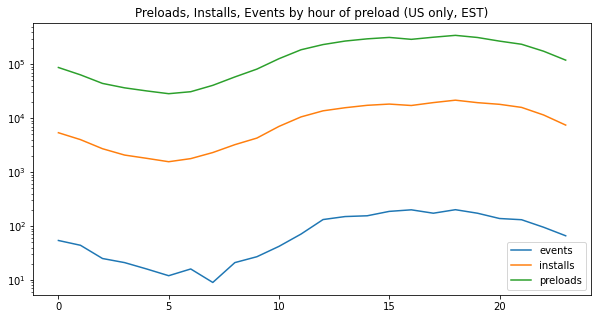

In [30]:
filters = (df['countrycode'] == 'US') 
pivot = df[filters].pivot_table(values = ['preload_count','install_count','event_count'], index = 'preload_hour', aggfunc = np.sum)
plt.figure( figsize = (10,5))
plt.plot(pivot)
plt.yscale('log')
plt.legend(['events','installs','preloads'])
plt.title('Preloads, Installs, Events by hour of preload (US only, EST)')

Text(0.5, 1.0, 'conversion rates by hour of preload (US only, EST)')

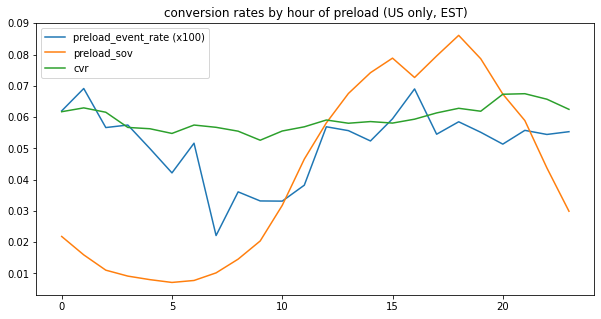

In [59]:
pivot['preload_event_rate'] = 100*pivot['event_count']/pivot['preload_count']
pivot['preload_sov'] = pivot['preload_count']/pivot['preload_count'].sum()
pivot['cvr'] = pivot['install_count']/pivot['preload_count']
plt.figure( figsize = (10,5))
plt.plot(pivot[['preload_event_rate','preload_sov', 'cvr']])
# plt.yscale('log')
plt.legend(['preload_event_rate (x100)','preload_sov', 'cvr'])
plt.title('conversion rates by hour of preload (US only, EST)')


<AxesSubplot:>

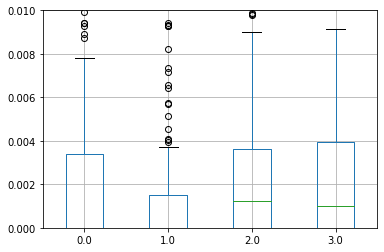

In [78]:
has_events = df.loc[df.event_count > 0, 'campaign_id'].to_list()
filters = (df.countrycode == 'US') & (df.campaign_id.isin(has_events))
by_hour = df[filters].pivot_table(values = ['event_count', 'preload_count'], index = ['campaign_id','hour_group'], aggfunc = np.sum)
by_hour['preload_event_rate'] = by_hour['event_count']/by_hour['preload_count']
by_hour.reset_index(inplace = True)
plt.ylim(0,.01)
by_hour.pivot_table(values = 'preload_event_rate', index = 'campaign_id', columns = 'hour_group', aggfunc = np.sum).boxplot()
